# 1. 소개
"Attention is all you need" 논문 구현

🔥[자세한 이론](http://jalammar.github.io/illustrated-transformer/)

트랜스포머 모델은 기본적으로 **인코더-디코더** 구조이고 이는 언어모델에서는 흔한 구조이다.  
<img src="images/1.encoder_decoder.png" alt="enc-dec.png" width="500" height="300">

위 이미지를 살펴보면 프랑스어 -> 영어 번역이 진행된걸 볼 수 있다.  
위에서는 각각 하나의 인코더, 디코더를 사용하지만 실제로는 여러 개의 인코더, 디코더를 쌓아서 사용할 수 있다.  
<img src="images/1.encoder_decoder_stack.png" alt="enc-dec.png" width="500" height="300">

아래는 **트랜스포머** 의 전체적인 구조이다.  

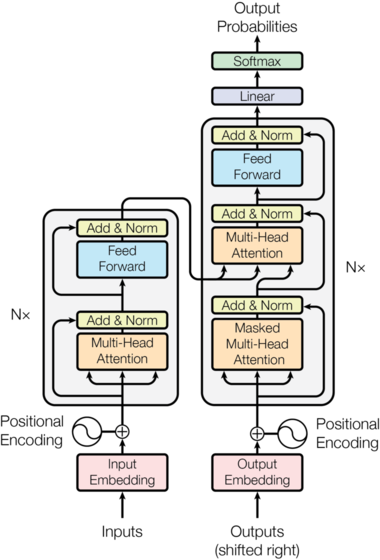

# 2. 라이브러리 임포트

### Conda 환경 구성
```python
conda create -n transformer python=3.10
```
```shell
conda install pytorch==2.2.2 pytorch-cuda=12.1 -c pytorch -c nvidia
pip install pandas seaborn matplotlib
```

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
warnings.simplefilter("ignore")

# 3. 기본 구성 요소
## 3.1 Create Word Embedding
<img src="images/2.word_embedding.png" alt="enc-dec.png" width="700" height="400">

우선 입력 시퀀스의 단어를 임베딩 벡터로 변환해야한다. 이 임베딩 벡터는 각 단어의 **의미론적 표현(semantic representation)** 을 담고 있다.  
임베딩 벡터의 **dimension(크기)** 가 512 차원이고 우리의 **vocab size(단어 개수)** 가 100이라고 한다면, 임베딩 매트릭스는 **100 x 512** 가 될 것이다.  
이 행렬들은 훈련하는 동안 학습되고 추론하는 동안 상응하는 512 차원 벡터에 맵핑된다.  

가령, batch_size = 32이고 시퀀스 길이가 10일때(10개의 단어)  
output = 32 x 10 x 512

In [3]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        '''
        Args:
            vocab_size : 단어 개수
            embed_dim : 임베딩 차원
        '''
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim)
    def forward(self, x):
        '''
        Args:
            x : input vector (1차원, 단순한 단어 - 숫자 맵핑)
        Returns:
            out : embedding vector
        '''

        out = self.embed(x)
        return out

### Embedding 실습

#### 실행 과정 설명
1. 인스턴스 생성: 
```embedding_layer = Embedding(vocab_size=100, embed_dim=50)``` 코드가 실행되면, Embedding 클래스의 인스턴스가 생성됨.

2. __init__ 호출: 
Embedding 클래스의 `__init__` 메서드가 자동으로 호출됨. 
이 메서드는 vocab_size와 embed_dim을 인자로 받아, `nn.Embedding` 레이어를 초기화하고 
이를 `self.embed` 속성에 저장

3. 부모 클래스 초기화: 
`super(Embedding, self).__init__()`가 호출되어 `nn.Module`의 기본 초기화 작업을 수행
이 단계는 PyTorch의 모듈 기능이 제대로 작동하도록 함.

4. 속성 설정: 
`self.embed` 속성이 `nn.Embedding` 레이어로 설정.
단어 인덱스를 임베딩 벡터로 변환하는 기능.

In [4]:
embedding_layer = Embedding(vocab_size=100, embed_dim=50)
print(embedding_layer)

Embedding(
  (embed): Embedding(100, 50)
)


## 3.2 Positional Encoding
다음 단계는 포지셔널 인코딩을 생성하는 것이다. 모델이 문장을 이해하려면 다음 두가지가 필요하다.  
1. 단어의 **의미** 를 이해
2. 문장에서 해당 단어의 **위치** 가 어디인지

논문에서는 저자들이 포지셔널 인코딩을 생성하기 위해 다음과 같은 함수를 사용함.

홀수 타임스텝에서 cosine 함수를 사용하고, 짝수 타임스텝에서 sine 함수를 사용함.

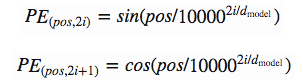

여기서 `pos`는 문장 내의 위치/순서를 의미하고 `i`는 임베딩 벡터 dimension에 따른 위치

PE는 임베딩 행렬과 비슷한 행렬을 생성한다. 생성된 행렬 : [sequence length] x [embedding dimension]

시퀀스의 각 토큰(단어)의 임베딩 벡터는 1 x 512 차원을 가지고 상응하는 포지셔널 벡터에 더해진다.

가령, 배치 사이즈 = 32, 시퀀스 길이 = 10, 임베딩 벡터 크기 = 512라 하자.

이 경우 임베딩 벡터의 차원은 32 x 10 x 512가 되고 포지셔널 인코딩 벡터의 차원 또한 32 x 10 x 512가 된다.

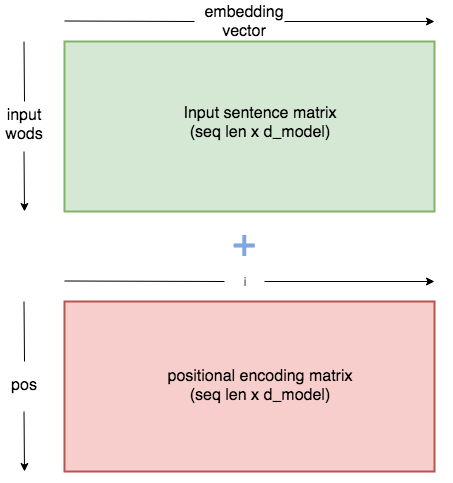

In [5]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_seq_len, embed_model_dim):
        ''' 
        Args:
            seq_len: input sequence의 길이
            embed_model_dim: 임베딩의 차원
        '''
        super(PositionalEmbedding, self).__init__()
        self.embed_dim  = embed_model_dim

        pe = torch.zeros(max_seq_len, self.embed_dim) # 2차원 배열 pe 초기화 [seq_len, d_model]
        for pos in range(max_seq_len):
            for i in range(0,self.embed_dim,2):
                pe[pos,i] = math.sin(pos/(10000 ** ((2 * i)/self.embed_dim)))
                pe[pos,i+1] = math.cos(pos/ (10000 ** ((2 * (i+1))/self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe',pe)

    def forward(self,x):
        ''' 
        Args:
            x: input vector
        Returns:
            x : output
        '''
        
        # 임베딩 크기 증가
        x = x * math.sqrt(self.embed_dim)
        
        # 임베딩에 상수 추가
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        
        return x

#### def __init__
1. positional embedding을 저장할 2차원 리스트 pe를 초기화하고 앞서 설명한 수식에 따라 pe 값을 세팅한다.

2. pe를 `unsqueeze(0)` 해서 첫 번째 차원에 1차원을 추가해서 3차원으로 만든다 => 배치 차원을 맞추기 위해 10 x 512 -> 1 x 10 x 512

3. `self.register_buffer('pe',pe)`를 수행해서 'pe'를 모듈의 버퍼로 등록한다. 버퍼에 등록된 리스트는 모델의 파라미터는 아니지만 모델의 상태로 저장되어서 학습 중에 업데이트 되지 않는다.

#### forward
1. `x = x * math.sqrt(self.embed_dim)`
    논문에서 제안한 스케일링 방식으로 임베딩 값의 크기를 조정해서 임베딩과 포지셔널 인코딩이 잘 결합되도록 한다.

2. x에 포지셔널 인코딩을 추가 == 임베딩 벡터에 포지셔널 정보를 추가
    원본 벡터 x에 `torch.autograd.Variable`로 인코딩 값을 래핑해서 포지셔널 인코딩이 학습되지 않게 한다.

## 3.3 Self Attention
#### self attention이란?
문장 내의 각 단어가 **다른 단어간의 관계** 를 고려해서 정보를 처리할 수 있게 해주는 메커니즘.

예를 들어서, "Dog is crossing the street because it saw the kitchen"라는 문장에서 

**"it"** 이 무엇을 가리키는지는 사람은 바로 알지만, 기계는 바로 알지 못한다.

**self-attention** 은 각 단어가 입력 시퀀스의 서로 다른 위치의 단어를 참조해서 단어간 관계를 파악하는데 도움을 준다.

이를 통해 각 **단어간 종속성**을 기반으로 벡터를 생성한다.


### Self Attention 단계별 설명

#### Step 1
인코더의 input vector(단어 임베딩)에서 **Query, Key, Value** 라 불리는 3개의 벡터를 생성한다.

이 벡터들은 각각 1 x 64 차원의 벡터이고 Multi-Head Attention의 경우 8개의 Self Attention Head가 있고 
지금 예제에서도 8개의 Self Attention Head가 있다고 가정하자.

##### Key, Query, Value 벡터는 어떻게 생성될까?
Key, Query, Value 벡터는 각각의 행렬을 사용해서 생성된다. 

각각의 행렬은 학습가능한 가중치 행렬이라고 생각하면 된다.

즉, Key, Query, Value Matrix를 통해서 각각의 벡터를 생성한다.

예를 들어, `batch_size=32, sequence_length=10, embedding dimension=512`라 하자.

임베딩을 하고 포지셔널 인코딩을 더해서 출력값을 구하면 **32x10x512** 차원이 된다.

우리는 이 결과값을 32x10x**8x64** 차원으로 resize한다. 여기서 8은 셀프 어텐션 헤드의 개수이다.

#### Step 2
두번째 단계는 score를 계산하는 것이다. 예를 들어 query 행렬과 key 행렬을 곱할 것이다.

가령, key, query, value의 차원이 32x10x8x64라 하자. 연산의 편의를 위해서 각 행렬을 Transpose 해서 

Query는 32x**8x10**x64로, Key는 32x**8**x64x**10**으로 transpose한다. 

이후 전치한 두 행렬을 곱하면 (32x8x10x64) x (32x8x64x10) -> (32x8x10x10) 이 된다.

#### Step 3
Output 행렬을 key 행렬의 차원의 제곱근으로 나누고 `softmax`를 적용한다.

가령, 32x8x10x10 벡터의 각 원소를 8(64의 제곱근)로 나눈다.

#### Step 4
위 결과를 value 행렬과 곱한다.

Step 3의 출력값의 차원은 32x8x10x10이고 이를 value 행렬(32x8x10x64)과 곱하면 **32x8x10x64** 차원의 결과값이 생성된다.

여기서 8은 셀프 어텐션 헤드 수, 10은 시퀀스 길이이다. 따라서, 각 단어는 차원의 크기가 64이다.

#### Step 5
앞선 출력값을 Linear Layer에 전달한다. 이 값이 멀티헤드 어텐션의 최종 출력값이다

32x8x10x64 차원 행렬이 32x10x8x64 차원으로 전치되고 32x10x512로 다시 reshape 된다.

선형 층을 통과한 최종 결과값의 차원은 **32x10x512**이다.

#### Step 2 Implementation

In [28]:
import torch

# 텐서 크기 설정
batch_size = 32
num_heads = 8
seq_len = 10
hidden_dim = 64

# Query: (32, 10, 8, 64)
Q = torch.randn(batch_size, seq_len, num_heads, hidden_dim)

# Key: (32, 10, 8, 64)
K = torch.randn(batch_size, seq_len, num_heads, hidden_dim)

# Query Transpose -> (32, 8, 10, 64)
Q_T = Q.transpose(-3, -2)  # 마지막 두 차원 transpose

# Key Transpose -> (32, 8, 64, 10)
K_T = K.transpose(-3, -1)  # 마지막과 두번째 차원 transpose
K_T = K_T.transpose(-3, -2)  # 마지막 두 차원 transpose

# 행렬 곱: (32, 8, 10, 64) x (32, 8, 64, 10) → (32, 8, 10, 10)
scores = torch.matmul(Q_T, K_T)

print("Query shape:", Q.shape)
print("Query Transpose shape:", Q_T.shape)
print("Key shape:", K.shape)
print("Key Transpose shape:", K_T.shape)

print("Scores shape:", scores.shape)

Query shape: torch.Size([32, 10, 8, 64])
Query Transpose shape: torch.Size([32, 8, 10, 64])
Key shape: torch.Size([32, 10, 8, 64])
Key Transpose shape: torch.Size([32, 8, 64, 10])
Scores shape: torch.Size([32, 8, 10, 10])


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim = 512, n_heads=8):
        '''
        Args:
            embed_dim: 임베딩 벡터 output의 차원
            n_heads: 셀프 어텐션 헤드 개수
        '''
        super(MultiHeadAttention,self).__init__()


        self.embed_dim = embed_dim # 512
        self.n_heads = n_heads # 8
        self.single_head_dim = int(self.embed_dim/self.n_heads) # 512/8 = 64

        # key, query, value matrices = 64 x 64
        self.query_matrix = nn.Linear(self.single_head_dim,self.single_head_dim,bias=False)
        self.key_matrix = nn.Linear(self.single_head_dim,self.single_head_dim,bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim,self.single_head_dim,bias=False)
        
        # out matrix = 512 x 512
        self.out = nn.Linear(self.n_heads * self.single_head_dim, self.embed_dim)

    def forward(self, key, query, value, mask=None):
        # batch size x sequence length x embeding dim = 32 x 10 x 512
        ''' 
        Args:
            key : key vector
            query : query vector
            value : value vector
            mask : 디코더를 위한 mask

        Returns:
            멀티헤드어텐션의 output 벡터
        '''

        batch_size = key.size(0)
        seq_length = key.size(1)

        # query의 차원은 추론시에 디코더에서 바뀔 수 있기 때문에 일반적인 seq_length를 받을 수 없고 따로 정의해야한다.
        seq_length_query = query.size(1)

        # 32x10x512-> 32x10x8x64
        # batch_size x sequence_length x n_heads x single_head_dimension = 32 x 10 x 8 x 64
        key = key.view(batch_size, seq_length,self.n_heads,self.single_head_dim)
        query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim)
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim)


        k = self.key_matrix(key)
        q = self.query_matrix(query)
        v = self.value_matrix(value)


        # batch_size, n_heads, sequence_length, single_head_dim = 32 x 8 x 10 x 64
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)
        

        # 어텐션 연산
        # 행렬곱 연산을 위해서 key를 조정
        # batch_size, n_heads, single_head_dim, sequence_len) = 32 x 8 x 64 x 10
        k_adjusted = k.transpose(-1,-2)
        
        # (32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = (32 x 8 x 10 x 10)
        product = torch.matmul(q,k_adjusted)
        

        # mask position이 0인 곳을 "-1e20"으로 채워준다.
        if mask is not None:
            product = product.masked_fill(mask == 0, float("-1e20"))

        # key의 차원의 제곱근으로 나눠준다
        product = product / math.sqrt(self.single_head_dim) # / sqrt(64)

        # softmax 적용
        scores = F.softmax(product, dim = -1)

        # value 행렬로 곱해준다
        # (32 x 8 x 10 x 10) x (32 x 8 x 10 x 64) = 32 x 8 x 10 x 64
        scores = torch.matmul(scores, v)
        

        # output concat
        # 32 x 8 x 10 x 64 -> 32 x 10 x 8 x 64 -> 32 x 10 x 512
        concat = scores.transpose(1,2).contiguous().view(batch_size,seq_length_query,self.single_head_dim*self.n_heads)
        
        # 32 x 10 x 512 -> 32 x 10 x 512
        output = self.out(concat) 
        

        return output

- `view` 메서드의 역할은 텐서의 차원을 바꾸는데 사용된다. 데이터는 변하지 않고 형태만 변화한다.
    - `view` 메서드에서 한 차원의 크기를 -1로 설정해서 자동으로 계산하게 할 수 있다.
    - `reshape` 과의 차이는 `reshape`의 경우 경우에 따라서 메모리 재배치가 필요할 수 있는데
    `view`의 경우에는 원본 메모르 블록을 재사용해서 원본 텐서와 같은 메모리를 공유한다.

- `masked_fill` 메서드의 역할은 pytorch 텐서의 특정 위치에 값을 채우는 데 사용한다.
    - mask를 사용해서 텐서의 일부 원소를 특정 값으로 대체할 수 있다.
    - 셀프 어텐션에서는 특정 원소를 무시하거나 제외할 때 사용된다.
    - `tensor.masked_fill(mask, value)` 에서 `mask`는 마스크를 채우려는 위치를 지정하는데 사용한다. 보통 True, False 값을 가진 boolean 텐서이고 `value`는 마스크가 True인 위치에 채울 값이다.
    - 어텐션 메커니즘에서 마스크는 주로 패딩 토큰이나 특정 위치를 무시하기 위해 사용된다. 
    예를 들어, 문장 길이가 다른 입력을 배치로 처리할 때, 패딩 토큰이 포함된 위치를 무시하기 위해 마스크를 사용할 수 있다.

- `contiguous` : 텐서의 데이터를 메모리에서 연속적인 블록으로 정렬하는 데 사용.
    - view 변경: PyTorch에서는 텐서의 모양을 바꾸기 위해 view, transpose, permute 등의 메서드를 사용할 수 있다. 텐서의 데이터가 메모리에서 연속적으로 저장되어 있지 않더라도 새로운 view를 제공한다.
    - 연속 메모리 필요: 많은 PyTorch 연산과 함수는 텐서의 데이터가 메모리에서 연속적으로 저장되어 있기를 예상함. 연속적이지 않은 텐서에 대해 이러한 연산을 수행하려고 하면 오류가 발생하거나 성능이 저하될 수 있기에 contiguous로 연속적인 텐서로 만들어준다.
    - 데이터 복사: contiguous 메서드는 필요한 경우 데이터를 복사하여 메모리에서 연속적인 블록으로 배열한다. 당연히 처음 비용은 비싸지만 반복적인 연산이 필요한 경우 후속 연산이 더 빠르고 안정적으로 수행된다.

`concat = scores.transpose(1,2).contiguous().view(batch_size,seq_length_query,self.single_head_dim*self.n_heads)`

위 부분을 살펴보자. view를 호출하여 새로운 형태로 텐서를 재구성한다. 

view는 연속적인 메모리 블록에서만 제대로 동작하기 때문에 contiguous가 호출된 후 view를 사용하는 것이 중요하다.


### 4. Encoder

<img src="images/4.encoder.png" alt="enc-dec.png" width="300" height="500">

#### Step 1 
입력 데이터(문장에 해당하는 패딩된 토큰들)가 임베딩 레이어와 포지셔널 인코딩 레이어를 통과  
입력이 (32 x 10) (배치 크기=32, 시퀀스 길이=10)일 경우, 임베딩 레이어를 통과하면 32 x 10 x 512가 된다.  
여기에 해당하는 포지셔널 인코딩 벡터를 더하면 32 x 10 x 512가 출력되고 이 출력은 멀티헤드 어텐션에 전달된다.

#### Step 2
입력 임베딩에 포지셔널 인코딩이 더해진 값은 멀티헤드 어텐션 레이어를 통과하여 유용한 representational matrix을 생성  
멀티헤드 어텐션의 입력은 32 x 10 x 512이며, 여기서 key, query, value 벡터가 생성된다.  
최종적으로 32 x 10 x 512 크기의 출력이 생성된다.

#### Step 3
정규화와 잔차 연결 (Residual Connection) 수행  
멀티헤드 어텐션 출력은 입력될때의 값과 더해지고, 정규화됩니다.  
멀티헤드 어텐션의 출력 (32 x 10 x 512)은 임베딩 레이어 출력 (32 x 10 x 512)과 더해지고, 그 결과가 정규화됩니다.

#### Step 4
Feedforward 레이어, 정규화, 잔차 연결 수행  
정규화된 출력은 Feedforward 레이어를 통과한 후 다시 정규화되고, 입력과의 잔차 연결이 이루어집니다. 이로써 최종적으로 인코더의 출력이 생성됩니다.  

정규화된 출력 (32 x 10 x 512)은 두 개의 선형 레이어를 통과합니다:  
32 x 10 x 512 -> 32 x 10 x 2048 -> 32 x 10 x 512  

결과적으로 잔차 연결이 이루어지고 정규화되어 최종 출력은 32 x 10 x 512 크기를 가지게 됩니다.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(TransformerBlock, self).__init__()
        """
        Args:
            embed_dim : embedding의 차원
            expansion_factor : linear layer의 output 차원을 결정하는 factor
            n_heads : # of attention head
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.feed_forward = nn.sequential(
            nn.Linear(embed_dim, expansion_factor * embed_dim),
            nn.ReLU(),
            nn.Linear(expansion_factor * embed_dim, embed_dim)
        )

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
    
    def forward(self, key, query, value):

        """
        Args:
            key : key vector
            query : query vector
            value : value vector
        
        Returns:
            norm2_out : transformer block의 출력
        """
        # 여기가 좀 복잡한데 그림과 함께보면 이해가 쉽습니다.

        attention_out = self.attention(key, query, value) # 32 x 10 x 512
        attention_residual_out = attention_out + value # 32 x 10 x 512
        norm1_out = self.dropout1(self.norm1(attention_residual_out)) # 32 x 10 x 512

        feed_fwd_out = self.feed_forward(norm1_out) # 32 x 10 x 512 -> 32 x 10 x 2048 -> 32 x 10 x 512
        feed_fwd_residual_out = feed_fwd_out + norm1_out # 32 x 10 x 512
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out)) # 32 x 10 x 512

        return norm2_out

class TransformerEncoder(nn.Module):
    """
    Args:
        seq_len : input sequence 길이
        embed_dim : embedding 차원
        num_layers : # of encoder layers
        expansion_factor : feed forward layer 내부의 linear layer의 개수를 정하는 factor
        n_heads : 멀티헤드 어텐션 헤드 개수
    
    Returns:
        out : encoder 출력값
    """

    def __init__(self, seq_len, vocab_size, embed_dim, num_layers = 2, expansion_factor = 4, n_heads = 8):
        super(TransformerEncoder, self).__init__()

        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList([TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(num_layers)])
    
    def forward(self, x):
        embed_out = self.embedding_layer(x)
        out = self.positional_encoder(embed_out)
        for layer in self.layers:
            out = layer(out,out,out)

        return out # 32 x 10 x 512

### 5. Decoder
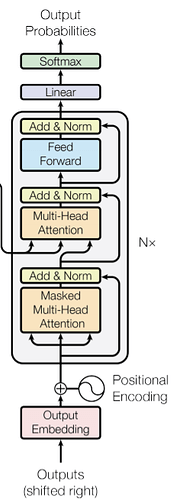

디코더에서는 인코더의 출력을 사용하여 디코더용 key와 value 벡터를 생성합니다.  
디코더에는 두 가지 종류의 multi-head attention이 있습니다.  
하나는 디코더 self-attention이고, 다른 하나는 인코더-디코더 attention입니다.  
이번에는 **학습 단계(training phase)**를 기준으로 설명하겠습니다.  

### Step 1:
먼저 target sequence에 대해 각 단어에 대해 embedding과 positional encoding을 통해 차원이 1 x 512인 임베딩 벡터를 생성합니다  

가령, sequence length : 10, batch size : 32, embedding dimension : 512라 할때,  
input size : 32 x 10 -> 임베딩 행렬 -> output size : 32 x 10 x 512  
여기에 같은 dimension의 positional encoding을 더해 최종적으로 32 x 10 x 512의 크기의 출력이 만들어 집니다.  

### Step 2: 
임베딩 출력은 다시 multi-head attention 레이어를 거칩니다.(target 입력으로 부터 key, query, value 행렬 생성)  
이 단계의 특별한 차이점은 **mask**를 사용한다는 것  
**왜 mask를 사용할까?**  

mask는 미래의 단어를 보지 않기 위해 사용됩니다.
attention을 사용하는 이유는 단어간의 관계(contribution)을 학습하기 위함인데,  
target sequence의 attention에서는 미래의 단어까지 참조하면 안되기 때문입니다. 

예를 들어,  "I am a student"라는 문장에서 "a"라는 단어가 "student"라는 미래 단어를 참고하면 안 됩니다.

attention을 만들 때 아래와 같이 삼각 행렬(triangular matrix)을 만듭니다.(시퀀스 길이 = 5):

```
1 0 0 0 0
1 1 0 0 0
1 1 1 0 0
1 1 1 1 0
1 1 1 1 1
```
key와 query를 곱한 후, 0인 위치에는 매우 작은 값(e.g. ,-1e20)으로 채운다.  
이를 통해 나중에 softmax 계산 시에 해당 위치가 거의 0으로 처리된다.

### Step 3:
앞서와 마찬가지로 attention 결과와 임베딩 출력을 더한 후 **정규화(normalization)**를 수행한다.(Add & Norm Layer)

### Step 4:
다음으로 또 다른 multi-head attention layer가 있는데, 이것이 encoder-decoder multi-head attention이다.
여기에서는 key와 value는 인코더 출력을 이용해서 생성하고, query는 디코더의 이전 레이어 출력을 사용한다.

Encoder Output은 32 x 10 x 512 이고,  
이로부터 key, value가 생성된다.  
query는 디코더의 이전 레이어 출력(32 x 10 x 512) 로부터 생성된다.  

이렇게 만든 key, value, query를 multi-head attention에 통과시킨다. (head 개수 = 8 사용)
그 후, Add & Norm 레이어를 통해 이전 디코더 레이어 출력과 attention 출력을 더하고 정규화한다.

### Step 5:
그 다음은 인코더와 동일하게 Feed Forward Layer(선형 레이어)와 Add & Norm 레이어를 거친다.

### Step 6:
마지막으로 전체 타깃 단어 집합 크기(어휘 크기) 만큼 길이를 가지는 선형 레이어를 만들고, softmax 함수를 적용하여 각 단어에 대한 확률 분포를 얻는다.